In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
import os
import pickle
sys.path.append(os.path.abspath(os.path.join("../")))
sys.path.append(os.path.abspath(os.path.join("../", "lib", "pysgmcmc/")))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

# Training model
from models.continual_training_dyn import TrainingDynamics

/home/thobotics/anaconda2/envs/tf14/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Generate data 

In [3]:
def f(x):
#     return np.sin(x)
    # return 1.5*np.sinc(x) - 0.5
    return 1.5*np.sinc(0.5*x - 2.5) - 0.15

def generate_data(sample_size=2000, low=-2*math.pi, high=-math.pi, seed=42):
    def sinus_model(x):
        return np.sin(1.5*x + np.pi/8.)

    rng = np.random.seed(seed)
    
    x = np.random.uniform(low=low, high=high, size=(sample_size,))
    y = f(x) + np.random.normal(0, 0.0225*np.abs(sinus_model(x)), sample_size)
    
    return x, y

def generate_original_data(sample_size = 2000, seed=42):
    def sinus_model(x):
        return np.sin(1.5*x + np.pi/8.)

    rng = np.random.seed(seed)
    
#     x1 = np.random.uniform(low=-2*math.pi, high=-math.pi, size=(sample_size // 2,))
#     x2 = np.random.uniform(low=math.pi, high=2*math.pi, size=(sample_size // 2,))
# #     x2 = np.random.uniform(low=-1.0, high=2., size=(sample_size // 2,))
#     x = np.hstack([x1, x2])
    x = np.random.uniform(low=-2*math.pi, high=-math.pi, size=(sample_size))
    y = f(x) + np.random.normal(0, 0.0225*np.abs(sinus_model(x)), sample_size)
    
    return x, y

In [4]:
# Generate data
x_train, y_train = generate_original_data(500)

x_validate = np.arange(-10., 10., 0.01)
y_validate = f(x_validate)

# Convert to matrix
x_train = x_train[:, np.newaxis]
y_train = y_train[:, np.newaxis]

x_validate = x_validate[:, np.newaxis]
y_validate = y_validate[:, np.newaxis]

In [5]:
def plot_model(x_tr=None, y_tr=None):
    
    # Setup state for plotting
    plt.rcParams['figure.figsize'] = (10, 5)               
    fig = plt.figure()
    
    plt.plot(x_validate, y_validate, 'r', label = '$m$')
    plt.scatter(x_train, y_train, color = 'blue', s = 15.5)
    
    if x_tr is not None:
        plt.scatter(x_tr, y_tr, color = 'k', s = 1.5)
    
    plt.xlim([-8., 8.])
    plt.ylim([-1.5, 1.5])

    plt.grid()
    plt.show()

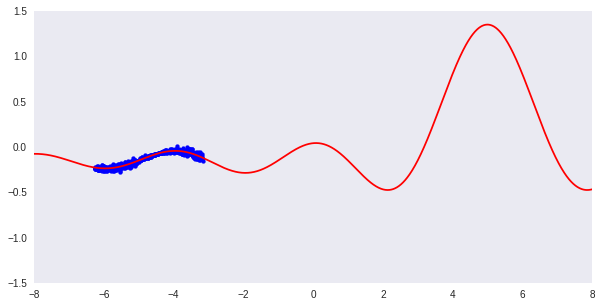

In [6]:
plot_model()

## Training 

In [7]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

tf.reset_default_graph()

# Create model
n_timestep = 1
n_inputs  = 1
n_outputs = 1

training = TrainingDynamics(n_inputs, n_outputs, n_timestep, action_bounds=([-1., -1.57], [1., 1.57]),
                          model_type="ME", n_nets=15, n_units=500, scale=1.5,
                          activation=tf.tanh, batch_size=100, a0=1.0, b0=0.1, a1=1.0, b1=5.0)

DEBUG:root:num_training_dynamics_adam_variables 270


In [8]:
# Add data
u_train = np.array([]).reshape(x_train.shape[0], 0)
training.add_data(x_train, u_train, y_train)

In [9]:
training.run_normal(x_validate, y_validate, step_size=1.0e-3, max_iters=1500)

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Training
INFO:root:Iter        0 : 
	NLL     = [73.31305, 93.14302, 111.804474, 83.35968, 110.15929, 70.52403, 92.53755, 76.17658, 99.89811, 105.58904, 70.76674, 79.86478, 128.73355, 77.720535, 123.472664] 
	NLL_val = [9386.401, 9675.507, 10009.409, 9793.215, 9810.935, 9854.155, 9747.381, 9526.543, 9886.584, 9879.742, 9617.427, 9919.027, 10211.438, 9769.184, 9676.402] 
	MSE     = [14.905892, 18.876568, 22.61259, 16.917894, 22.283228, 14.348243, 18.755327, 15.479886, 20.228905, 21.368227, 14.396766, 16.218248, 26.000166, 15.788986, 24.948566] 
	MSE_val = [1879.3883, 1937.2675, 2004.1145, 1960.8326, 1964.38, 1973.0327, 1951.6566, 1907.4448, 1979.5249, 1978.1553, 1925.6398, 1986.0203, 2044.5608, 1956.0216, 1937.4465] 
Time =  4.64
INFO:root:Iter      250 : 
	NLL     = [7.343643, 8.2048, 8.337845, 10.154911, 7.528713, 6.791129, 7.3020744, 7.3867655, 7.459097, 8.013915, 7.100424, 7.2229295, 8.203069, 8.422932, 7.6970634] 
	NLL_val = [5725

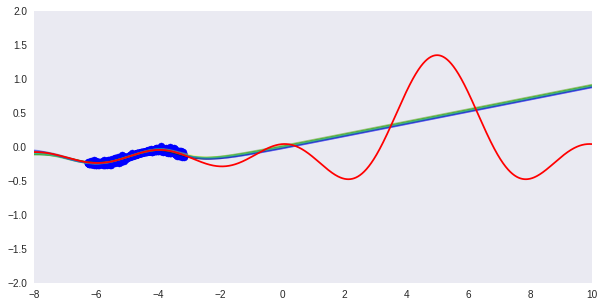

In [10]:
def plot_bnn_model(x_new=None, y_new=None):
    
    # Setup state for plotting
    plt.rcParams['figure.figsize'] = (10, 5)               
    fig = plt.figure()

    color = ['green', 'k', 'yellow', 'cyan', "blue"]
    
    for i in range(training.model.n_nets):
        y_pred, _ = training.predict(x_validate, return_individual_predictions=True, model_idx=i)
        plt.plot(x_validate, y_pred, color[i % 5], alpha=0.35)
    
    plt.plot(x_validate, y_validate, 'r', label = '$m$')
    plt.scatter(training.xu, training.y, color='blue', s=50.5)
    
    if x_new is not None:
        plt.scatter(x_new, y_new, color='black', s=50.5)
    
    # Plot last model
    # y_pred, _ = training.predict(x_validate, normal=True, return_individual_predictions=True, model_idx=training.model.n_nets-1)
    # plt.plot(x_validate, y_pred, "black", alpha=1.0, linewidth=3)
    
    plt.xlim([-8., 10.])
    plt.ylim([-2.0, 2.0])

    plt.grid()
    plt.show()
        
plot_bnn_model()

# Online Learning

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Training
INFO:root:Iter        0 : 
	NLL     = [63.466095, 83.79783, 71.877655, 70.34146, 86.3928, 67.064384, 75.228745, 71.330635, 78.131516, 81.36471, 63.796288, 79.197075, 93.05968, 68.46651, 84.62855] 
	NLL_val = [2056.88, 2252.492, 2288.9905, 2159.565, 2303.28, 2132.743, 2245.1863, 2089.6118, 2342.478, 2354.3572, 2078.3145, 2159.0842, 2499.6768, 2216.1863, 2339.0127] 
	MSE     = [25.915691, 31.453342, 26.473469, 27.418402, 31.80648, 26.382996, 28.224222, 28.644186, 28.0699, 29.130053, 25.757673, 30.856947, 31.401094, 25.9984, 30.75251] 
	MSE_val = [829.8233, 837.41724, 833.54944, 832.40344, 840.0577, 829.26306, 833.3786, 830.0901, 832.7189, 834.38226, 829.0192, 832.9367, 835.7852, 831.744, 841.77844] 
Time =  0.13
INFO:root:Iter      250 : 
	NLL     = [2.2375565, 2.507518, 2.5434418, 2.3850958, 2.5529816, 2.3018475, 2.5457685, 2.2500122, 2.5833929, 2.59402, 2.2520597, 2.3381367, 2.7572436, 2.45739, 2.5633254] 
	NLL_val = [1990.5

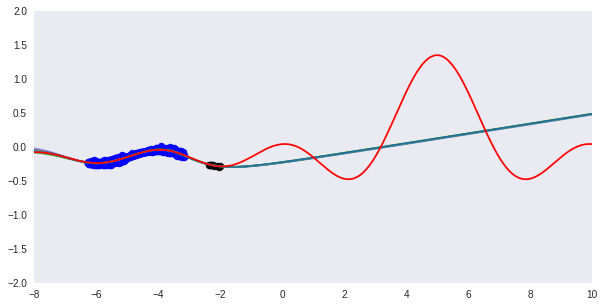

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Training
INFO:root:Iter        0 : 
	NLL     = [58.045124, 71.28721, 71.03591, 62.059715, 74.69202, 58.454556, 66.90284, 61.81634, 69.43672, 66.95843, 59.84698, 64.289825, 75.98624, 64.78341, 77.092255] 
	NLL_val = [1905.6051, 1981.706, 2132.788, 1952.3572, 2075.8013, 1908.0406, 2033.2299, 1872.9746, 2139.8064, 2114.437, 1883.7413, 1903.1351, 2274.0396, 2013.4615, 2096.2473] 
	MSE     = [28.943336, 34.03224, 31.663969, 30.132687, 34.44866, 29.090475, 31.370253, 31.206919, 30.908247, 30.174894, 30.025837, 32.055424, 31.937155, 30.506542, 34.94188] 
	MSE_val = [939.27936, 936.9749, 941.0585, 937.581, 948.3941, 938.703, 943.46136, 935.44824, 942.60785, 942.6999, 934.61523, 939.1006, 946.38654, 937.99, 941.3843] 
Time =  0.16
INFO:root:Iter      250 : 
	NLL     = [2.574352, 2.9637465, 3.2464213, 2.8038511, 3.2525258, 2.712582, 3.0142963, 2.4765487, 3.2294917, 3.0465345, 2.5360658, 2.6480274, 3.5270462, 2.844654, 3.4020698] 
	NLL_val = [1

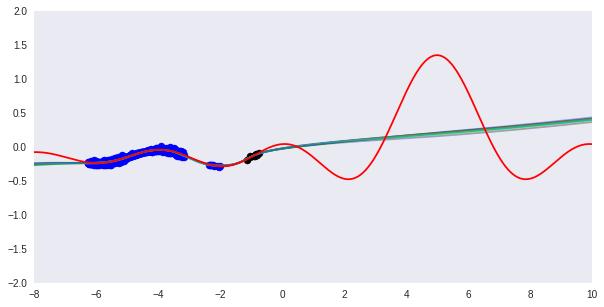

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Training
INFO:root:Iter        0 : 
	NLL     = [24.884783, 26.23984, 29.120556, 25.253487, 28.966627, 26.037657, 26.75737, 23.283627, 26.178583, 29.169662, 24.400934, 25.836246, 31.946318, 25.515474, 29.045155] 
	NLL_val = [853.3117, 877.3326, 915.5728, 875.0655, 909.9187, 851.5216, 894.7858, 816.8942, 930.1858, 925.1834, 832.9508, 847.7756, 983.43115, 874.2103, 900.5063] 
	MSE     = [17.75385, 17.817867, 18.85376, 17.335459, 19.33615, 18.459414, 17.989563, 16.963919, 16.79909, 18.972214, 17.75829, 18.430847, 19.556831, 17.43437, 19.02814] 
	MSE_val = [596.6441, 583.94855, 581.7619, 588.44885, 596.3569, 592.1245, 589.7982, 582.7281, 584.43286, 590.62634, 594.10126, 593.17346, 591.3431, 585.23505, 579.0699] 
Time =  0.16
INFO:root:Iter      250 : 
	NLL     = [2.628284, 1.786018, 1.7798642, 1.9078201, 1.8240622, 2.200325, 1.8637165, 2.5323403, 2.1837826, 2.0051186, 2.1059399, 1.9841055, 2.0212154, 1.8232685, 1.6885399] 
	NLL_val = [845

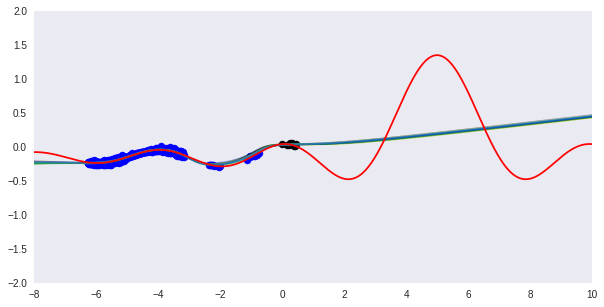

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Training
INFO:root:Iter        0 : 
	NLL     = [15.118687, 16.198498, 16.658926, 16.264631, 14.892925, 14.478819, 15.288178, 14.7681465, 16.146044, 16.11373, 15.463764, 15.050515, 16.678812, 15.285176, 16.503258] 
	NLL_val = [503.45724, 517.2798, 542.52576, 517.6141, 519.4875, 504.88562, 523.7524, 495.6827, 544.32684, 542.7034, 499.24817, 500.01114, 562.2979, 519.1217, 533.40936] 
	MSE     = [12.80914, 13.19095, 12.982142, 13.288461, 11.993915, 12.178987, 12.320137, 12.744339, 12.490018, 12.562068, 13.250439, 12.739726, 12.387717, 12.450349, 13.008184] 
	MSE_val = [414.84232, 409.9781, 411.26413, 411.6828, 406.01974, 412.3996, 409.9536, 415.98456, 409.1297, 411.1575, 416.47247, 411.56198, 405.6849, 410.8449, 409.01755] 
Time =  0.22
INFO:root:Iter      250 : 
	NLL     = [2.2644968, 1.8578542, 2.0005696, 2.0137222, 2.457581, 1.9094458, 1.9335445, 2.278138, 2.183744, 2.16639, 2.2633827, 1.8516134, 2.311005, 2.3929648, 1.8487312] 
	NLL_

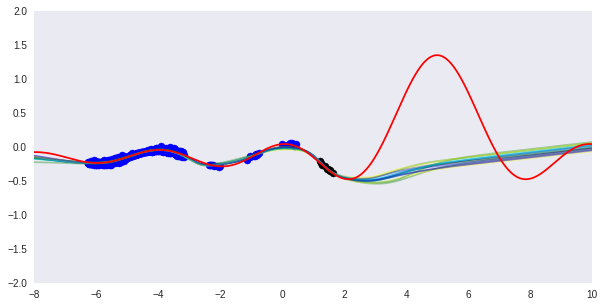

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Training
INFO:root:Iter        0 : 
	NLL     = [7.651696, 8.556765, 9.63505, 8.712009, 8.635014, 9.522735, 9.320385, 8.42846, 9.486812, 9.316509, 6.474965, 9.39803, 9.503412, 7.9090333, 10.129391] 
	NLL_val = [875.0911, 831.6083, 834.28436, 821.9191, 829.7019, 773.88403, 865.1459, 850.3533, 870.97174, 836.03, 838.5085, 823.0711, 838.6418, 836.0827, 886.7657] 
	MSE     = [7.0692363, 7.571217, 8.163027, 7.70819, 7.6253276, 8.50407, 8.150336, 7.8768663, 7.9577894, 7.9130664, 6.096449, 8.477422, 7.7292027, 7.068398, 8.666714] 
	MSE_val = [767.8384, 701.0771, 675.7321, 693.499, 698.32544, 662.17865, 723.3226, 759.0383, 697.5665, 677.85864, 743.5371, 711.30896, 650.2594, 709.4301, 727.32623] 
Time =  0.11
INFO:root:Iter      250 : 
	NLL     = [7.357179, 9.234783, 4.438248, 7.9404006, 11.052645, 7.3470807, 8.904098, 5.976211, 8.291909, 4.1998305, 2.3907087, 3.916441, 5.2397923, 3.0104907, 6.746034] 
	NLL_val = [374.3782, 394.69302, 410.8022

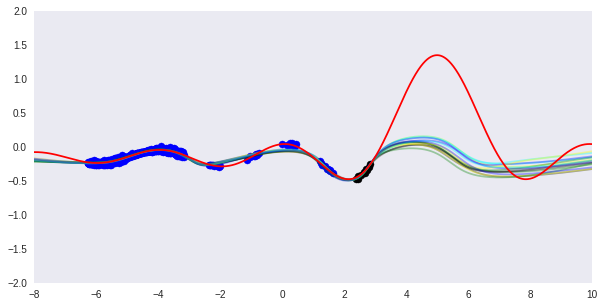

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Training
INFO:root:Iter        0 : 
	NLL     = [67.86247, 66.00961, 63.911785, 68.6865, 66.26519, 63.684563, 67.84975, 60.902313, 63.04197, 62.24228, 70.573746, 63.012436, 68.37869, 65.22318, 66.60696] 
	NLL_val = [174.73317, 166.8151, 219.8019, 217.60454, 199.19258, 172.36182, 175.66202, 163.86803, 210.24358, 211.86798, 148.43356, 170.16087, 182.65144, 188.91806, 197.85857] 
	MSE     = [63.149303, 58.67995, 56.556274, 61.342663, 58.9843, 58.26863, 60.619823, 57.353523, 55.985615, 54.906578, 66.20608, 57.49275, 58.581013, 58.837395, 59.04455] 
	MSE_val = [162.04312, 147.74757, 193.6333, 193.56561, 176.59064, 157.09947, 156.37798, 153.72609, 185.87686, 186.03787, 138.86058, 154.65282, 155.87946, 169.74747, 174.69052] 
Time =  0.20
INFO:root:Iter      250 : 
	NLL     = [1.2318864, 1.7402511, 1.4134588, 1.5039508, 0.6455311, 1.4408433, 1.3726811, 1.5964637, 1.4136263, 1.4252781, 2.1094944, 0.93842185, 0.6958468, 1.0162362, 1.3235623] 
	

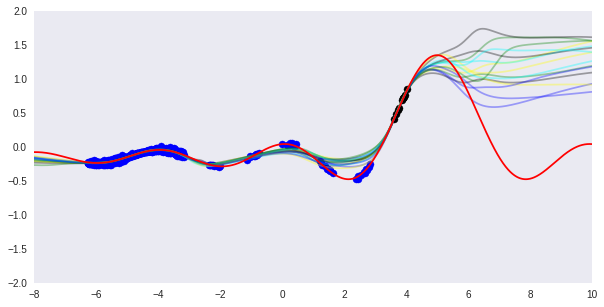

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Training
INFO:root:Iter        0 : 
	NLL     = [4.876128, 5.146753, 5.449844, 5.045, 6.1074843, 5.083766, 5.1872873, 5.0744386, 5.0911727, 4.8927317, 5.082764, 5.071649, 5.910811, 5.5271535, 5.392026] 
	NLL_val = [207.33855, 263.4247, 189.18878, 205.29225, 149.38737, 172.64963, 162.6916, 172.26021, 180.43724, 159.56514, 152.41888, 215.25854, 210.58347, 205.2282, 166.35907] 
	MSE     = [4.608294, 4.6484613, 4.9089665, 4.5707054, 5.427399, 4.672828, 4.679544, 4.8019686, 4.60501, 4.4177456, 4.873818, 4.675885, 5.107066, 5.010632, 4.85888] 
	MSE_val = [181.04169, 219.7544, 158.21162, 171.62737, 124.255905, 146.79747, 135.77495, 151.19386, 150.74104, 132.62334, 135.79166, 183.51094, 169.35556, 172.9905, 139.10616] 
Time =  0.11
INFO:root:Iter      250 : 
	NLL     = [2.0562093, 4.9274526, 3.9416988, 3.0806413, 3.6759763, 3.4174907, 3.1583064, 4.11128, 4.5813265, 3.471285, 3.7942564, 1.5930363, 3.3915236, 4.0433993, 2.7908285] 
	NLL_val = [

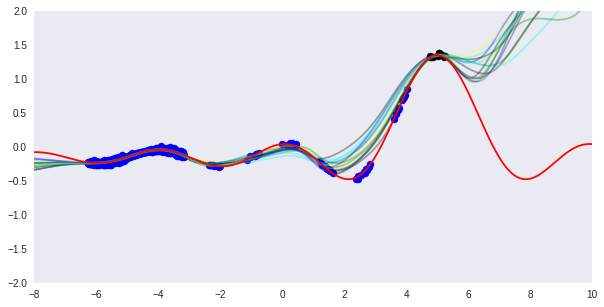

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Training
INFO:root:Iter        0 : 
	NLL     = [10.367406, 9.95493, 8.23325, 7.008017, 8.106103, 8.9624195, 6.27277, 7.353698, 7.5337014, 10.4727125, 8.313881, 11.243007, 9.908507, 7.4840226, 8.1961565] 
	NLL_val = [77.47708, 80.906105, 77.03079, 79.277695, 76.619194, 81.5379, 75.091156, 79.63287, 75.98568, 74.510025, 71.04867, 79.84363, 77.37208, 74.77689, 67.37846] 
	MSE     = [8.59944, 8.34021, 6.952612, 5.9712777, 6.826178, 7.612207, 5.4315395, 6.4960356, 6.427558, 8.609862, 7.30265, 9.036514, 7.992104, 6.383794, 7.0195103] 
	MSE_val = [61.909557, 65.19162, 62.01031, 63.79897, 61.44649, 66.31254, 61.03455, 66.78906, 61.526566, 59.030037, 59.677563, 61.949177, 59.924515, 60.515648, 55.084118] 
Time =  0.15
INFO:root:Iter      250 : 
	NLL     = [-0.24764684, -0.25619888, -0.09840423, 0.036963284, -0.12967126, -0.26789278, 0.17576417, -0.14068823, 0.10537069, -0.27408582, -0.12575892, -0.3244079, -0.26541916, -0.044510685, -0.131238

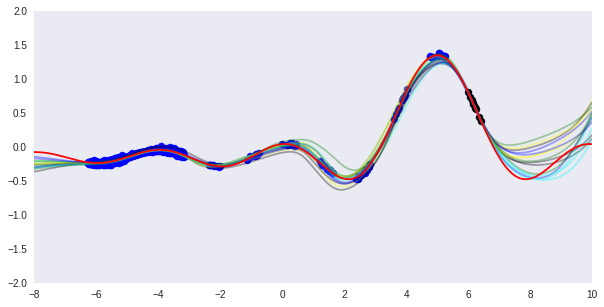

INFO:root:Reinitialize dynamics Adam
INFO:root:Start Training
INFO:root:Iter        0 : 
	NLL     = [25.307228, 35.579575, 30.320312, 26.254238, 30.719288, 28.852978, 25.778622, 25.740456, 32.352, 30.446058, 25.871702, 34.967533, 25.064077, 30.21987, 29.764713] 
	NLL_val = [93.1341, 133.55763, 110.90047, 96.65083, 113.58354, 107.4402, 94.859436, 93.24937, 121.31143, 112.37957, 96.07018, 129.03876, 90.55273, 110.48053, 110.58102] 
	MSE     = [12.503411, 15.043623, 15.312768, 13.784959, 14.031477, 13.3209505, 13.668204, 13.598423, 14.326976, 13.544029, 13.116137, 14.174883, 12.971808, 14.327102, 14.3230505] 
	MSE_val = [45.101677, 55.577946, 55.09644, 49.81792, 50.983727, 48.69467, 49.364895, 48.352463, 52.817047, 49.105473, 47.773438, 51.450844, 45.963562, 51.484226, 52.29432] 
Time =  0.11
INFO:root:Iter      250 : 
	NLL     = [0.4380592, 4.3225985, 4.6308722, 1.8968635, 0.8655699, 0.5669856, 0.9651059, 6.292334, 6.7171087, 2.5785162, 1.7415215, 2.5023832, 1.0939429, 0.011992254, 12.59

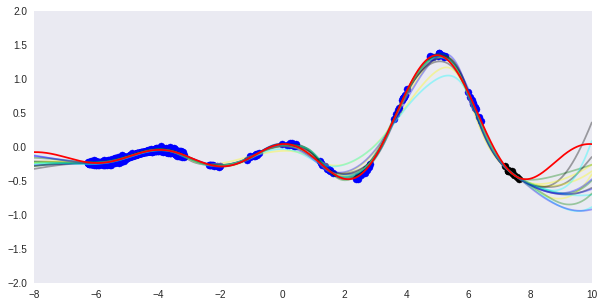

In [11]:
from IPython import display

start = -math.pi + 0.7

for i in range(9):
    
    x_train_new = np.array([]).reshape((0, 1))
    y_train_new = np.array([]).reshape((0, 1))
    
    for j in range(1):
        # x_new, y_new = generate_data(10, low=-math.pi + i*0.5, high=0.5*math.pi + i*0.5, seed=22 + i*5)
        x_new, y_new = generate_data(10, low=start, high=start+0.5, seed=22 + i*5)
        start = start + 0.5 + 0.7

        x_train_new = np.vstack([x_train_new, x_new[:, np.newaxis]])
        y_train_new = np.vstack([y_train_new, y_new[:, np.newaxis]])
    
    u_train_new = np.array([]).reshape(x_train_new.shape[0], 0)

    # Fit data
    training._fit(x_train_new, u_train_new, y_train_new)
    
    training.run_normal(x_validate, y_validate, x_train_new, y_train_new, step_size=1.0e-3, max_iters=1500)

    
#     training.add_data(x_train_new, u_train_new, y_train_new)

#     training.run_normal(x_validate, y_validate, step_size=1e-3, max_iters=2000)
#     training.run_bnn(x_validate, y_validate, step_size=2.0e-3, mdecay=0.05, burn_in_steps=3000, n_iters=250000, sample_steps=100)

    plot_bnn_model(x_train_new, y_train_new)

    # Add data
    training.add_data(x_train_new, u_train_new, y_train_new, fit=False)
    
    display.display()

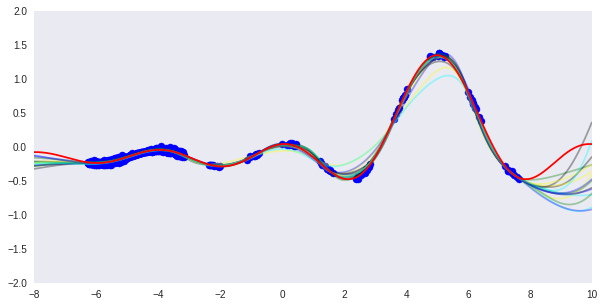

In [12]:
plot_bnn_model()

In [13]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

tf.reset_default_graph()

# Create model
n_timestep = 1
n_inputs  = 1
n_outputs = 1

training_new = TrainingDynamics(n_inputs, n_outputs, n_timestep, action_bounds=([-1., -1.57], [1., 1.57]),
                          model_type="ME", n_nets=15, n_units=500, scale=1.5,
                          activation=tf.tanh, batch_size=100, a0=1.0, b0=0.1, a1=1.0, b1=5.0)

# Add data
x_train = training.xu
y_train = training.y
u_train = np.array([]).reshape(x_train.shape[0], 0)
training_new.add_data(x_train, u_train, y_train)

training_new.run_normal(x_validate, y_validate, step_size=1e-3, max_iters=3000)

DEBUG:root:num_training_dynamics_adam_variables 270
INFO:root:Reinitialize dynamics Adam
INFO:root:Start Training
INFO:root:Iter        0 : 
	NLL     = [47.800842, 212.71745, 52.09785, 304.75198, 181.95578, 275.14145, 62.452328, 61.725677, 163.03865, 150.96191, 70.14482, 250.77101, 306.32986, 333.36157, 224.59737] 
	NLL_val = [184.7226, 1309.6487, 152.80515, 1597.8932, 1042.6664, 1509.382, 189.55737, 184.05919, 999.7515, 819.2176, 225.2564, 1476.4968, 1590.6868, 1796.0092, 1239.5255] 
	MSE     = [9.799048, 42.81554, 10.657014, 61.24065, 36.655262, 55.310627, 12.732445, 12.586917, 32.869247, 30.452063, 14.271423, 50.433308, 61.556244, 66.96838, 45.19362] 
	MSE_val = [37.211555, 262.42194, 30.821, 320.12845, 208.97151, 302.4079, 38.179523, 37.07877, 200.38028, 164.23756, 45.32616, 295.82477, 318.68567, 359.7913, 248.38316] 
Time =  5.18
INFO:root:Iter      250 : 
	NLL     = [25.51687, 24.568012, 28.645905, 30.221554, 28.370739, 25.601864, 24.112724, 25.291248, 28.197443, 28.573788, 24.18

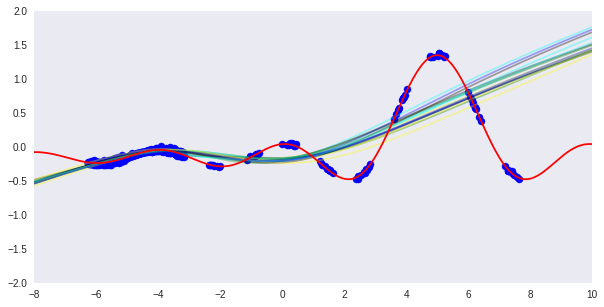

In [14]:
 # Setup state for plotting
plt.rcParams['figure.figsize'] = (10, 5)               
fig = plt.figure()

color = ['green', 'k', 'yellow', 'cyan', "blue"]

for i in range(training.model.n_nets):
    y_pred, _ = training_new.predict(x_validate, return_individual_predictions=True, model_idx=i)
    plt.plot(x_validate, y_pred, color[i % 5], alpha=0.35)

plt.plot(x_validate, y_validate, 'r', label = '$m$')
plt.scatter(training_new.xu, training_new.y, color='blue', s=50.5)

# Plot last model
#y_pred, _ = training.predict(x_validate, normal=True, return_individual_predictions=True, model_idx=training.model.n_nets-1)
#plt.plot(x_validate, y_pred, "black", alpha=1.0, linewidth=3)

plt.xlim([-8., 10.])
plt.ylim([-2.0, 2.0])

plt.grid()
plt.show()